In [64]:
"""
Qick based qubit measurement example (maybe LC tank?)

RF Out     ____~~~~~~~~~~~~~~~~~~~~. . . .~~~~~~~~~~~~~~~~~~~~___
Digitizer  ____|‾‾‾‾‾|_|‾‾‾‾‾|_|‾‾‾. . . .‾‾‾|_|‾‾‾‾‾|_|‾‾‾‾‾|___
Measured Data   IQ[0]   IQ[1]      . . . .      IQ[78]  IQ[79]
"""
import numpy as np
import math
import matplotlib.pyplot as plt
import time

from qick import *
from qick.averager_program import QickSweep
from qick.pyro import make_proxy

class LongDurationPulseExample(NDAveragerProgram):
    def initialize(self):
        # set the nyquist zone
        cfg = self.cfg
        freq_rf     = cfg["freq_rf"]
        # Declare RF generation channel
        self.declare_gen(
            ch      = 0,        # Channel
            nqz     = 1         # Nyquist Zone
        )

        # Declare RF input channel
        self.declare_readout(
            ch      = 0,        # Channel
            length  = int(cfg["pulse_time"] * 3/4) - 10,       # Readout length
        )
        # Convert RF frequency to DAC DDS register value
        self.freq_dac = self.freq2reg(
            f       = freq_rf,  # Frequency
            gen_ch  = 0,        # Generator channel
            ro_ch   = 0         # Readout channel for round up
        )
        # Convert RF frequency to ADC DDS register value
        freq_adc    = self.freq2reg_adc(
            f       = freq_rf,  # Frequency
            ro_ch   = 0,        # Readout channel
            gen_ch  = 0         # Generator channel for round up
        )
        # Set demodulator DDS
        self.set_readout_registers(
            ch      = 0,        # Readout channel
            freq    = freq_adc, # Readout DDS frequency
            length  = 16, # Readout DDS multiplication length
            phrst   = 0,        # Readout DDS phase reset
        )
        self.synci(100000)

    def body(self):
        cfg = self.cfg
        self.readout(
            ch      = 0,        # Readout channel
            t       = 100       # Readout DDS will start multiplication
                                # @ sync_t + 100
        )
        self.setup_and_pulse(
            ch      = 0,        # Generator channel
            style   = "const",    # Output is envelope * gain * DDS output
            freq    = self.freq_dac, # Generator DDS frequency
            phase   = self.deg2reg(0, gen_ch = 0),        # Generator DDS phase
            gain    = cfg["gain"], # Generator amplitude
            phrst   = 0,        # Generator DDS phase reset
            length  = 100,       # Total length of envelope.
            mode    = "periodic", # Set pulse mode to periodic
            t       = 100
        )
        self.sync_all(100)
        for i in range(cfg["number_of_pulse"]):
            self.trigger(
                adcs    = [0],      # Readout channels
                adc_trig_offset = 150 + i * cfg["pulse_time"] # Readout will capture the data @ sync_t + 50
            )

        self.sync_all(100)
        self.setup_and_pulse(
            ch      = 0,        # Generator channel
            style   = "const",  # Output is envelope * gain * DDS output
            freq    = self.freq_dac, # Generator DDS frequency
            phase   = self.deg2reg(0, gen_ch = 0),    # Generator DDS phase
            gain    = 0,        # Generator amplitude
            phrst   = 0,        # Generator DDS phase reset
            length  = 100,      # Total length of envelope.
            mode    = "oneshot", # Set pulse mode to periodic
            t       = 100 + cfg["pulse_time"]
        )
        self.sync_all(1000)
        self.wait_all()


Pyro.NameServer PYRO:Pyro.NameServer@0.0.0.0:8888
myqick PYRO:obj_38f24800b8e744bfb6326c66ea9ca7fa@192.168.2.99:38083
meas time : 0.975 ms


100%|██████████| 1/1 [00:00<00:00, 180.45it/s]

Acquisition time for : 0.0565643310546875 s


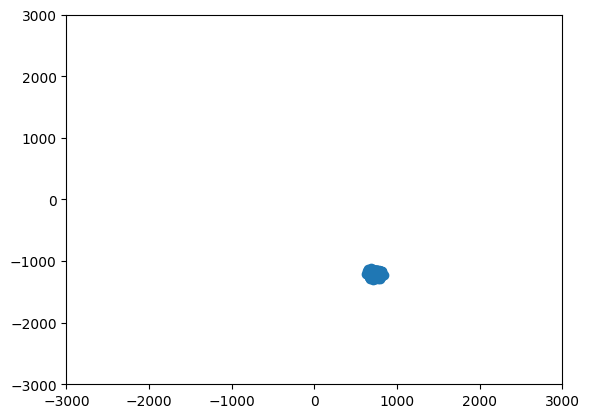

31.408032197059697
34.78666646037137


In [70]:

# Qick version : 0.2.357
(soc, soccfg) = make_proxy("192.168.2.99")
# print(soccfg)

# Set DAC Channel 0 attenuation 10 dB and 10 dB, and turn on DAC channel
soc.rfb_set_gen_rf(0,0,0)
# Set DAC Channel filter as bypass mode
soc.rfb_set_gen_filter(0,fc = 2.5, ftype = "lowpass")

# Set ADC Channel attenuation 31 dB, and turn on ADC channel
soc.rfb_set_ro_rf(0,31)
# Set ADC Channel filter as bypass mode
soc.rfb_set_ro_filter(0, fc = 2.5, ftype = "lowpass")

start_time = time.time()
# P_out = 19.7 * log10(gain) -77.0 (R = 0.999868) @ 540 MHz
cfg = {
    # Experiment Setup
    "reps" : 1,
    "expts" : 800,
    "freq_rf" : 540,
    "gain" : 200,
    # Parameter Setup
    "pulse_time" : 650,
    "number_of_pulse" : 600,
}
print("meas time : {:.3f} ms".format(cfg["pulse_time"] * cfg["number_of_pulse"] * 2.5 / 1e6 ))
# print(prog)
plt.figure()

cfg["gain"] = 100
prog = LongDurationPulseExample(
    soccfg,
    cfg,
)
expts, avgi, avgq  = prog.acquire(soc = soc, progress = True, start_src = "internal")
end_time = time.time()
# avgi = np.array(avgi[0]).mean(axis = 0)
# avgq = np.array(avgq[0]).mean(axis = 0)

print(f"Acquisition time for : {end_time - start_time} s")
plt.scatter(avgq, avgi)
plt.xlim([-3000 , 3000])
plt.ylim([-3000 , 3000])
plt.show()
print(np.array(avgi).std())
print(np.array(avgq).std())

Pyro.NameServer PYRO:Pyro.NameServer@0.0.0.0:8888
myqick PYRO:obj_38f24800b8e744bfb6326c66ea9ca7fa@192.168.2.99:38083
meas time : 0.975 ms


100%|██████████| 1/1 [00:00<00:00, 109.49it/s]

Acquisition time for : 0.04807758331298828 s


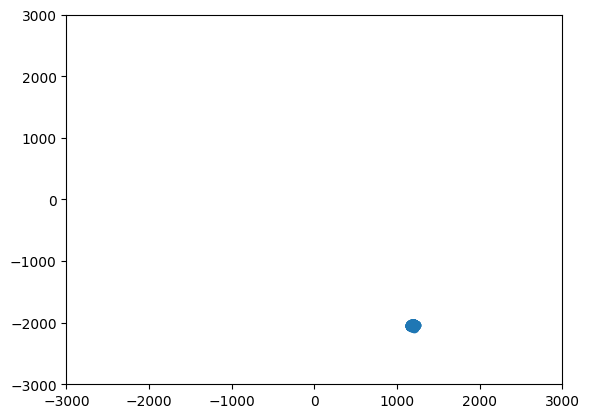

8.996086711045086
12.783006751543617


In [71]:

# Qick version : 0.2.357
(soc, soccfg) = make_proxy("192.168.2.99")
# print(soccfg)

# Set DAC Channel 0 attenuation 10 dB and 10 dB, and turn on DAC channel
soc.rfb_set_gen_rf(0,0,20)
# Set DAC Channel filter as bypass mode
soc.rfb_set_gen_filter(0,fc = 2.5, ftype = "lowpass")

# Set ADC Channel attenuation 31 dB, and turn on ADC channel
soc.rfb_set_ro_rf(0,31)
# Set ADC Channel filter as bypass mode
soc.rfb_set_ro_filter(0, fc = 2.5, ftype = "lowpass")

start_time = time.time()
# P_out = 19.7 * log10(gain) -77.0 (R = 0.999868) @ 540 MHz
cfg = {
    # Experiment Setup
    "reps" : 1,
    "expts" : 800,
    "freq_rf" : 540,
    "gain" : 2000,
    # Parameter Setup
    "pulse_time" : 650,
    "number_of_pulse" : 600,
}
print("meas time : {:.3f} ms".format(cfg["pulse_time"] * cfg["number_of_pulse"] * 2.5 / 1e6 ))
# print(prog)
plt.figure()

cfg["gain"] = 1000
prog = LongDurationPulseExample(
    soccfg,
    cfg,
)
expts, avgi, avgq  = prog.acquire(soc = soc, progress = True, start_src = "internal")
end_time = time.time()
# avgi = np.array(avgi[0]).mean(axis = 0)
# avgq = np.array(avgq[0]).mean(axis = 0)

print(f"Acquisition time for : {end_time - start_time} s")
plt.scatter(avgq, avgi)
plt.xlim([-3000 , 3000])
plt.ylim([-3000 , 3000])
plt.show()
print(np.array(avgi).std())
print(np.array(avgq).std())

Pyro.NameServer PYRO:Pyro.NameServer@0.0.0.0:8888
myqick PYRO:obj_38f24800b8e744bfb6326c66ea9ca7fa@192.168.2.99:38083
meas time : 0.975 ms


100%|██████████| 1/1 [00:00<00:00, 200.87it/s]

Acquisition time for : 0.05404329299926758 s


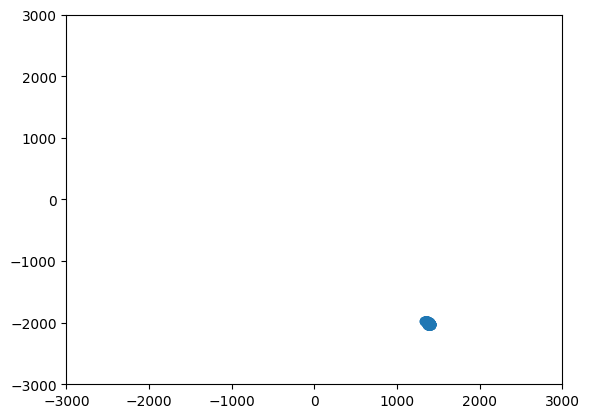

16.83474899891503
14.083595873560293


In [72]:

# Qick version : 0.2.357
(soc, soccfg) = make_proxy("192.168.2.99")
# print(soccfg)

# Set DAC Channel 0 attenuation 10 dB and 10 dB, and turn on DAC channel
soc.rfb_set_gen_rf(0,10,30)
# Set DAC Channel filter as bypass mode
soc.rfb_set_gen_filter(0,fc = 2.5, ftype = "lowpass")

# Set ADC Channel attenuation 31 dB, and turn on ADC channel
soc.rfb_set_ro_rf(0,31)
# Set ADC Channel filter as bypass mode
soc.rfb_set_ro_filter(0, fc = 2.5, ftype = "lowpass")

start_time = time.time()
# P_out = 19.7 * log10(gain) -77.0 (R = 0.999868) @ 540 MHz
cfg = {
    # Experiment Setup
    "reps" : 1,
    "expts" : 800,
    "freq_rf" : 540,
    "gain" : 2000,
    # Parameter Setup
    "pulse_time" : 650,
    "number_of_pulse" : 600,
}
print("meas time : {:.3f} ms".format(cfg["pulse_time"] * cfg["number_of_pulse"] * 2.5 / 1e6 ))
# print(prog)
plt.figure()

cfg["gain"] = 10000
prog = LongDurationPulseExample(
    soccfg,
    cfg,
)
expts, avgi, avgq  = prog.acquire(soc = soc, progress = True, start_src = "internal")
end_time = time.time()
# avgi = np.array(avgi[0]).mean(axis = 0)
# avgq = np.array(avgq[0]).mean(axis = 0)

print(f"Acquisition time for : {end_time - start_time} s")
plt.scatter(avgq, avgi)
plt.xlim([-3000 , 3000])
plt.ylim([-3000 , 3000])
plt.show()
print(np.array(avgi).std())
print(np.array(avgq).std())